In [41]:
import math
from importlib import reload
import os

import gc
import matplotlib.pyplot as plt
# import pickle
import numpy as np

from tqdm.notebook import tqdm
from tqdm import trange

from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time.environments import cartpole2
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

from pprint import pprint


from adaptive_time import mc2
import adaptive_time.utils
import gymnasium as gym
import random

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
cartpole2 = reload(cartpole2)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)



In [42]:
utils.set_directory_in_project()

Changed working directory to /Users/szepi1991/Code/adaptive_time


'/Users/szepi1991/Code/adaptive_time'

## Data Generation

In [43]:

SHOULD_TERMINATE = True
discrete_reward = True
GRAB_DETAILED_DATA = False


In [44]:
seed = 13
dt_scaler = 200.
new_dt = 0.02 / dt_scaler
STEPS_MAX = 20_000
STEPS_BREAK_FROM = 9_000

# NUM_TRAJS = 2
NUM_TRAJS = 100


In [45]:

if discrete_reward:
    reward_type = "discrete"
else:
    reward_type = "continuous"


BASE_DIR = "classic_control_data"
data_descr = f"cartpole2_rew_{reward_type}_term{SHOULD_TERMINATE}"
traj_data_file = f"{data_descr}.pkl"



In [46]:
utils.set_directory_in_project()
# traj_data_path = os.path.join(BASE_DIR, traj_data_file)


Changed working directory to /Users/szepi1991/Code/adaptive_time


'/Users/szepi1991/Code/adaptive_time'

In [76]:

_NUM_ACTIONS = 2
START_STATE = (0.0, 0.0, 0.0, 0.0)

class TrajGen:

    def __init__(self, epsilon, detailed_data=False) -> None:
        self.env = gym.make(
            'CartPole-OURS-v2',
            discrete_reward=discrete_reward,
            should_terminate=SHOULD_TERMINATE,
            step_time=new_dt)

        self.phi = run_lib.make_features()
        self._epsilon = epsilon
        self._detailed_data = detailed_data

        self.weights_good_policy = np.load("cartpole_weights_20240227-102913_ret92516.44719752521.npy")
        # self.weights_good_policy = np.load("cartpole_weights_20240227-102913_ret50756.37604280466.npy")

    def policy(self, state, num_step, weights, epsilon):
        if num_step >= STEPS_BREAK_FROM:
            # if random.random() < 0.95:  # spread of 60 at 100 trajs
            if random.random() < 0.9:
            # if random.random() < 0.55:  # a nice spread
                return 0   # Alway push in one direction.

        if random.random() < epsilon:
            action = self.env.action_space.sample()
            return action
        
        # Otherwise calculate the best action.
        x = self.phi.get_fourier_feature(state)
        qs = np.zeros(_NUM_ACTIONS)
        for action in range(_NUM_ACTIONS):
            x_sa = mc2.phi_sa(x, action)
            qs[action] = np.inner(x_sa.flatten(), weights)
        # adaptive_time.utils.softmax(qs, 1)
        
        return np.argmax(qs)
        # return adaptive_time.utils.argmax(qs)
        
    def generate_trajectory(self, num_trajs):
        total_rewards = []
        reward_sequences = []
        traj_lengths = []
        angles = []
        xs = []
        d_angles = []
        actions = []
        dxs = []
        for idx in tqdm(range(num_trajs)):
            # Tuple[float, float, float, float]
            trajectory, early_term = value_est.generate_trajectory(
                    self.env, start_state=START_STATE,
                    policy=lambda st, sn: self.policy(st, sn, self.weights_good_policy, self._epsilon),
                    # policy=policy,
                    termination_prob=0.0, max_steps=STEPS_MAX)

            traj_lengths.append(len(trajectory))
            rewards = [r for _, _, r, _ in trajectory]
            if self._detailed_data:
                actions.append([a for _, a, _, _ in trajectory])
                xs.append([s[0] for s, _, _, _ in trajectory])
                angles.append([s[2] for s, _, _, _ in trajectory])
                d_angles.append([s[3] for s, _, _, _ in trajectory])
                dxs.append([s[1] for s, _, _, _ in trajectory])
            reward_sequences.append(rewards)
            total_rewards.append(sum(rewards))

        total_rewards = np.array(total_rewards)
        # Reward sequences may be different lengths in the terminating
        # case, so we can't make a 2D array.
        if not SHOULD_TERMINATE:
            reward_sequences = np.array(reward_sequences)
            traj_lengths = np.array(traj_lengths)
            angles = np.array(angles)
            xs = np.array(xs)
            d_angles = np.array(d_angles)
            actions = np.array(actions)
            dxs = np.array(dxs)

        if self._detailed_data:
            details = (angles, xs, d_angles, actions, dxs)
        else:
            details = None
        all_traj_data = (
            total_rewards, reward_sequences, traj_lengths,
            details
        )
        # with open(traj_data_path, "wb") as f:
        #     pickle.dump(all_traj_data, f)
        # print("Saved data to", traj_data_path)

        # print(self.env.tau)

        # print("total_rewards for each traj:", total_rewards)
        # if hasattr(reward_sequences, "shape"):
        #     print("all rewards shape if array:", reward_sequences.shape)
        # num_trajs = len(total_rewards)
        return all_traj_data

In [77]:
traj_gen = TrajGen(1.0, detailed_data=False)
run_lib.reset_randomness(seed, traj_gen.env)
all_traj_data = traj_gen.generate_trajectory(100)
total_rewards, reward_sequences, traj_lengths, details = all_traj_data

print(total_rewards)


  0%|          | 0/100 [00:00<?, ?it/s]

[10765.  8632. 10935. 10583. 10222.  8215. 10403. 11063.  8273.  8228.
 11047.  8943.  8306.  7211.  8467. 10429.  8092. 11394. 12500. 11127.
 11207. 11431. 12106.  7788. 10562. 11746.  6828.  8685. 12246. 11330.
  8755.  8591. 10048. 12255. 11288. 10831.  8280.  8234.  8988.  9763.
 11256.  9633.  6569. 11055. 11785. 10344.  8898.  8827. 11893.  6521.
 11436.  7543.  9992.  6054.  8350. 12024.  9993.  7280. 11237. 10458.
  6828. 11370.  8347. 10621. 11934.  9263. 11263.  8254. 10529.  7965.
 10304.  8667. 11402. 11556.  7724.  9819. 11887. 11376.  9668. 11030.
  8697. 11875. 10363.  9115.  9956. 11987.  7478.  8802. 11410. 11910.
  7498.  6700. 10554.  7085. 12144.  8479. 10786. 12135. 10710.  9720.]


(array([ 3.,  6.,  6., 14., 11.,  5., 14., 13., 15., 13.]),
 array([ 6054. ,  6698.6,  7343.2,  7987.8,  8632.4,  9277. ,  9921.6,
        10566.2, 11210.8, 11855.4, 12500. ]),
 <BarContainer object of 10 artists>)

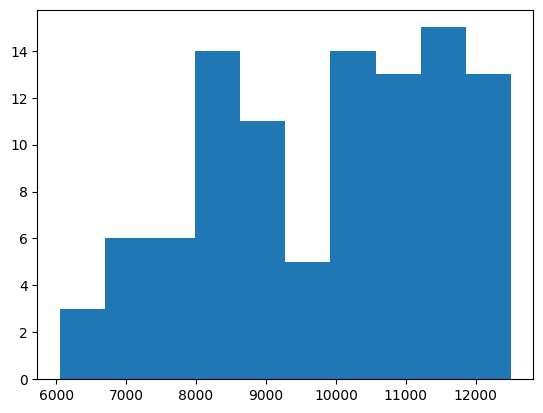

In [78]:
plt.hist(total_rewards)

## Data Processing

### Plot Styling

In [79]:
import seaborn as sns

sns.set_style("darkgrid")
sns.set_palette("colorblind")


def set_size(width_pt, fraction=1, subplots=(1, 1), use_golden_ratio=True):
    """
    Reference: https://jwalton.info/Matplotlib-latex-PGF/
    Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    if use_golden_ratio:
        # Golden ratio to set aesthetic figure height
        golden_ratio = (5**0.5 - 1) / 2

        # Figure height in inches
        fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])
    else:
        fig_height_in = fig_width_in * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


### Data Parameters

In [80]:
def name_to_param(name):
    num = float(name[1:])
    if name[0] == 'q':
        return num
    else:
        return int(num)

def name_to_type(name):
    return name[0]

def param_to_name(sampler_char, param):
    return f"{sampler_char}{param}"

In [81]:
# unif_sampler_params = np.power(2, np.arange(0, 11, 2))
# quad_sampler_params = np.concatenate(
#     (np.array([0]), np.power(2, np.arange(-3.0, 10, 2))), axis=0
# )

unif_sampler_params = np.array([1])
quad_sampler_params = np.array([1])

print('unif_sampler_params:', unif_sampler_params)
print('quad_sampler_params:', quad_sampler_params)


unif_sampler_params: [1]
quad_sampler_params: [1]


In [82]:
samplers_tried = {
    f'q{p}': approx_integrators.AdaptiveQuadratureIntegrator(tolerance=p)
    for p in quad_sampler_params
}
samplers_tried.update({
    f'u{p}': approx_integrators.UniformlySpacedIntegrator(p)
    for p in unif_sampler_params
})


In [83]:
gc.collect()

# NUM_RUNS = 100
# SAMPLE_BUDGET = 1_000_000
NUM_RUNS = 3
SAMPLE_BUDGET = 100_000
seed = 43

BUDGET_INTERP_STEP = 1_000

results_path = "results/cartpole_stoch_pol"

In [84]:
# # For testing
# def get_data_batch():
#     return total_rewards, reward_sequences

# Real.
traj_gen = TrajGen(1.0, detailed_data=False)
run_lib.reset_randomness(seed, traj_gen.env)

def get_data_batch(batch_size=100):
    all_traj_data = traj_gen.generate_trajectory(batch_size)
    total_rewards, reward_sequences, traj_lengths, details = all_traj_data
    return total_rewards, reward_sequences



In [85]:

samplers_to_learn_with = samplers_tried
# samplers_to_learn_with = {
#     'u1024': samplers_tried['u1024'],
# }


In [107]:


def process_batch_of_data(
        samplers_to_learn_with, update_budget,
        # Running estimates:
        return_estimates, samples_used_so_far,
        # Batch of new data:
        total_rewards, reward_sequences
    ):
    # Each trajectory is transformed, by a sampler, into a pair:
    #   * return estimate
    #   * number of samples used.
    # We then just store these.
    more_to_do = False
    
    for sampler_name, sampler in samplers_to_learn_with.items():
        # print("sampler_name:", sampler_name)
        try:
            num_samples_at_start = samples_used_so_far[sampler_name][-1]
        except IndexError:
            num_samples_at_start = 0
        # print(num_samples_at_start)

        if num_samples_at_start >= update_budget:
            continue

        num_trajs = len(reward_sequences)
        cur_returns = np.zeros((num_trajs,))
        cur_num_samples = np.zeros((num_trajs,))
        for idx, reward_seq in enumerate(reward_sequences):
            integral, all_pivots = sampler.integrate(reward_seq)
            cur_returns[idx] = integral
            cur_num_samples[idx] = len(all_pivots)
        # print("AA:\n", cur_num_samples)
        new_total_samples = np.cumsum(cur_num_samples) + num_samples_at_start
        # print(new_total_samples)
        samples_used_so_far[sampler_name] = np.concatenate(
                    (samples_used_so_far[sampler_name], new_total_samples))
        return_estimates[sampler_name] = np.concatenate(
                    (return_estimates[sampler_name], cur_returns))

        used_samples = samples_used_so_far[sampler_name][-1]
        if used_samples < update_budget:
            more_to_do = True

    return more_to_do



def single_run(samplers_to_learn_with, get_data_batch):
    return_estimates = {}
    samples_used_so_far = {}
    for sampler_name in samplers_to_learn_with.keys():
        return_estimates[sampler_name] = np.array([])
        samples_used_so_far[sampler_name] = np.array([])

    all_updates = SAMPLE_BUDGET
    last_processed_so_far = 0
    with tqdm(total=all_updates) as progress_bar:
        more_to_do = True
        iter_num = 0
        true_returns = np.array([])
        while more_to_do and iter_num < SAMPLE_BUDGET:
            total_rewards, reward_sequences = get_data_batch()
            iter_num += 1
            true_returns = np.concatenate((true_returns, total_rewards))
            more_to_do = process_batch_of_data(
                    samplers_to_learn_with, SAMPLE_BUDGET,
                    # Running estimates:
                    return_estimates, samples_used_so_far,
                    # Batch of new data:
                    total_rewards, reward_sequences)
            
            # Just for updating the progress bar -- use the slowest of all samplers.
            processed_so_far = {k: samples_used_so_far[k][-1] for k in samplers_to_learn_with.keys()}
            total_processed_so_far = min(processed_so_far.values())
            progress_bar.update(total_processed_so_far - last_processed_so_far)
            last_processed_so_far = total_processed_so_far
            # print({k: samples_used_so_far[k][-1] for k in samplers_to_learn_with.keys()})

    # Turn the return estimates into value estimates.
    value_estimates = {
        sn: np.cumsum(return_estimates[sn]) / np.arange(1, len(return_estimates[sn]) + 1)
        for sn in samplers_to_learn_with.keys()
    }
    return value_estimates, samples_used_so_far, true_returns    




In [114]:

# Finally will have a `data` structure with:
# data[sampler_name][run_idx]{running_v_estimate or total_pivots}[idx_of_trajectory_processed]
# * We can actually keep around just the `returns_ests` instead of `running_v_estimate`
# * But it makes sense to have `total_pivots` since we want to check against the budget.

run_lib.reset_randomness(seed, env=None)   # TODO check about seeding...

data = {k: [] for k in samplers_to_learn_with.keys()}
true_returns = np.array([])
for i in trange(NUM_RUNS):
    value_estimates, samples_used_so_far, true_returns = single_run(
        samplers_to_learn_with, get_data_batch)
    true_returns = np.concatenate((true_returns, total_rewards))    
    for sampler_name in samplers_to_learn_with.keys():
        data[sampler_name].append({
            "running_v_estimate": value_estimates[sampler_name],
            "total_pivots": samples_used_so_far[sampler_name],
        })


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

{'q1': 300.0, 'u1': 781836.0}
{'q1': 600.0, 'u1': 781836.0}
{'q1': 900.0, 'u1': 781836.0}
{'q1': 1200.0, 'u1': 781836.0}
{'q1': 1500.0, 'u1': 781836.0}
{'q1': 1800.0, 'u1': 781836.0}
{'q1': 2100.0, 'u1': 781836.0}
{'q1': 2400.0, 'u1': 781836.0}
{'q1': 2700.0, 'u1': 781836.0}
{'q1': 3000.0, 'u1': 781836.0}
{'q1': 3300.0, 'u1': 781836.0}
{'q1': 3600.0, 'u1': 781836.0}
{'q1': 3900.0, 'u1': 781836.0}
{'q1': 4200.0, 'u1': 781836.0}
{'q1': 4500.0, 'u1': 781836.0}
{'q1': 4800.0, 'u1': 781836.0}
{'q1': 5100.0, 'u1': 781836.0}
{'q1': 5400.0, 'u1': 781836.0}
{'q1': 5700.0, 'u1': 781836.0}
{'q1': 6000.0, 'u1': 781836.0}
{'q1': 6300.0, 'u1': 781836.0}
{'q1': 6600.0, 'u1': 781836.0}
{'q1': 6900.0, 'u1': 781836.0}
{'q1': 7200.0, 'u1': 781836.0}
{'q1': 7500.0, 'u1': 781836.0}
{'q1': 7800.0, 'u1': 781836.0}
{'q1': 8100.0, 'u1': 781836.0}
{'q1': 8400.0, 'u1': 781836.0}
{'q1': 8700.0, 'u1': 781836.0}
{'q1': 9000.0, 'u1': 781836.0}
{'q1': 9300.0, 'u1': 781836.0}
{'q1': 9600.0, 'u1': 781836.0}
{'q1': 9900

 33%|███▎      | 1/3 [00:05<00:10,  5.42s/it]

{'q1': 98700.0, 'u1': 781836.0}
{'q1': 99000.0, 'u1': 781836.0}
{'q1': 99300.0, 'u1': 781836.0}
{'q1': 99600.0, 'u1': 781836.0}
{'q1': 99900.0, 'u1': 781836.0}
{'q1': 100200.0, 'u1': 781836.0}


  0%|          | 0/100000 [00:00<?, ?it/s]

{'q1': 300.0, 'u1': 781836.0}
{'q1': 600.0, 'u1': 781836.0}
{'q1': 900.0, 'u1': 781836.0}
{'q1': 1200.0, 'u1': 781836.0}
{'q1': 1500.0, 'u1': 781836.0}
{'q1': 1800.0, 'u1': 781836.0}
{'q1': 2100.0, 'u1': 781836.0}
{'q1': 2400.0, 'u1': 781836.0}
{'q1': 2700.0, 'u1': 781836.0}
{'q1': 3000.0, 'u1': 781836.0}
{'q1': 3300.0, 'u1': 781836.0}
{'q1': 3600.0, 'u1': 781836.0}
{'q1': 3900.0, 'u1': 781836.0}
{'q1': 4200.0, 'u1': 781836.0}
{'q1': 4500.0, 'u1': 781836.0}
{'q1': 4800.0, 'u1': 781836.0}
{'q1': 5100.0, 'u1': 781836.0}
{'q1': 5400.0, 'u1': 781836.0}
{'q1': 5700.0, 'u1': 781836.0}
{'q1': 6000.0, 'u1': 781836.0}
{'q1': 6300.0, 'u1': 781836.0}
{'q1': 6600.0, 'u1': 781836.0}
{'q1': 6900.0, 'u1': 781836.0}
{'q1': 7200.0, 'u1': 781836.0}
{'q1': 7500.0, 'u1': 781836.0}
{'q1': 7800.0, 'u1': 781836.0}
{'q1': 8100.0, 'u1': 781836.0}
{'q1': 8400.0, 'u1': 781836.0}
{'q1': 8700.0, 'u1': 781836.0}
{'q1': 9000.0, 'u1': 781836.0}
{'q1': 9300.0, 'u1': 781836.0}
{'q1': 9600.0, 'u1': 781836.0}
{'q1': 9900

 67%|██████▋   | 2/3 [00:10<00:05,  5.41s/it]

{'q1': 99900.0, 'u1': 781836.0}
{'q1': 100200.0, 'u1': 781836.0}


  0%|          | 0/100000 [00:00<?, ?it/s]

{'q1': 300.0, 'u1': 781836.0}
{'q1': 600.0, 'u1': 781836.0}
{'q1': 900.0, 'u1': 781836.0}
{'q1': 1200.0, 'u1': 781836.0}
{'q1': 1500.0, 'u1': 781836.0}
{'q1': 1800.0, 'u1': 781836.0}
{'q1': 2100.0, 'u1': 781836.0}
{'q1': 2400.0, 'u1': 781836.0}
{'q1': 2700.0, 'u1': 781836.0}
{'q1': 3000.0, 'u1': 781836.0}
{'q1': 3300.0, 'u1': 781836.0}
{'q1': 3600.0, 'u1': 781836.0}
{'q1': 3900.0, 'u1': 781836.0}
{'q1': 4200.0, 'u1': 781836.0}
{'q1': 4500.0, 'u1': 781836.0}
{'q1': 4800.0, 'u1': 781836.0}
{'q1': 5100.0, 'u1': 781836.0}
{'q1': 5400.0, 'u1': 781836.0}
{'q1': 5700.0, 'u1': 781836.0}
{'q1': 6000.0, 'u1': 781836.0}
{'q1': 6300.0, 'u1': 781836.0}
{'q1': 6600.0, 'u1': 781836.0}
{'q1': 6900.0, 'u1': 781836.0}
{'q1': 7200.0, 'u1': 781836.0}
{'q1': 7500.0, 'u1': 781836.0}
{'q1': 7800.0, 'u1': 781836.0}
{'q1': 8100.0, 'u1': 781836.0}
{'q1': 8400.0, 'u1': 781836.0}
{'q1': 8700.0, 'u1': 781836.0}
{'q1': 9000.0, 'u1': 781836.0}
{'q1': 9300.0, 'u1': 781836.0}
{'q1': 9600.0, 'u1': 781836.0}
{'q1': 9900

100%|██████████| 3/3 [00:16<00:00,  5.40s/it]

{'q1': 100200.0, 'u1': 781836.0}


In [115]:
# Get more batches to get a good estimate of the true return.
for _ in tqdm(range(1000)):
    total_rewards, reward_sequences = get_data_batch()
    true_returns = np.concatenate((true_returns, total_rewards))

true_return_est = np.sum(true_returns) / len(true_returns)
true_return_95conf = 1.96 * np.std(true_returns) / math.sqrt(len(true_returns))

print(f"true_return_est: {true_return_est}+-{true_return_95conf}")


  0%|          | 0/100 [00:00<?, ?it/s]

true_return_est: 7818.36+-29.230385152151086


In [116]:
gc.collect()

4042

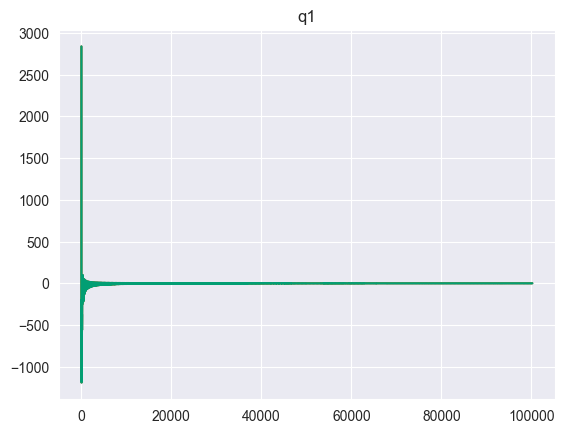

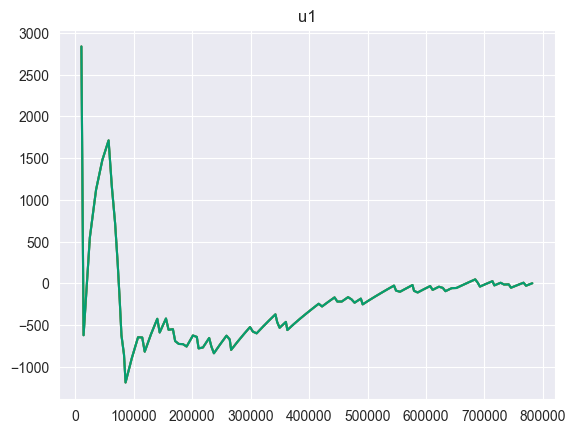

true_return_est: 7818.36+-29.230385152151086


In [117]:
for sampler_name in samplers_to_learn_with.keys():
    f = plt.figure()
        # data[sampler_name].append({
        #     "running_v_estimate": value_estimates[sampler_name],
        #     "total_pivots": samples_used_so_far[sampler_name],
        # })
    for run_data in data[sampler_name]:
        plt.plot(run_data["total_pivots"], run_data["running_v_estimate"] - true_return_est)
    # plt.plot(samples_used_so_far[sampler_name], value_estimates[sampler_name]-true_return_est)
    plt.title(sampler_name)
    plt.show()

print(f"true_return_est: {true_return_est}+-{true_return_95conf}")


## TODO UPDATE FROM HERE

PLUS, we gotta get new batches of data each time.

In [25]:
list(data.values())[0][0].keys()

dict_keys(['running_v_estimate', 'total_pivots'])

In [26]:
estimates_across_runs = np.array([ data["u256"][i]["running_v_estimate"][-1000] for i in range(NUM_RUNS) ])
estimates_across_runs

array([7809.40755144, 7809.18196786, 7807.18404865, 7835.12284724,
       7802.87019323, 7815.44784396, 7821.56912556, 7824.88687993,
       7821.73885112, 7818.88299108, 7813.91182917, 7813.71365946,
       7824.58893345, 7822.18148302, 7821.25746205, 7822.14578641,
       7827.51021707, 7827.75796204, 7816.70863931, 7827.83695114,
       7817.52574216, 7823.3849153 , 7805.2202806 , 7808.52514621,
       7811.92908152, 7819.20329088, 7836.08150423, 7831.06577711,
       7815.24753285, 7809.6840941 , 7810.7085585 , 7804.73606327,
       7817.40912718, 7826.1834931 , 7822.40259189, 7820.92153615,
       7810.85601156, 7806.02385834, 7821.88135473, 7830.96084888,
       7827.98454561, 7815.52764113, 7832.80513328, 7822.72111393,
       7811.94975808, 7816.76648721, 7819.84352683, 7801.72568964,
       7808.15747316, 7823.74027535, 7805.37098615, 7807.96800032,
       7832.43650064, 7800.36920839, 7820.54857022, 7813.90956657,
       7823.58689306, 7814.95006111, 7814.69422531, 7815.75874

In [27]:
gc.collect()

_values_data = plot_utils.process_across_runs(
        data, "total_pivots", "running_v_estimate", right=np.nan, interp_step=BUDGET_INTERP_STEP, tqdm=tqdm)

gc.collect()

_means = {
    k: np.abs(val - true_value)
    for k, val in _values_data.means.items()
}
error_data = _values_data._replace(means=_means)


interpolating


  0%|          | 0/14 [00:00<?, ?it/s]

finding means and stderrs


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/szepi1991/Code/adaptive_time/code/adaptive_time/plot_utils.py:70: RuntimeWarning: Mean of empty slice
  all_y_means[name] = np.nanmean(res, axis=0)
/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Plots

In [33]:
title = "Cartpole"
filename = data_descr

error_y_label = "$|v^\pi - \hat{v}|$"

utils.set_directory_in_project(results_path)

Changed working directory to /Users/szepi1991/Code/adaptive_time/results/cartpole_stoch_pol


'/Users/szepi1991/Code/adaptive_time/results/cartpole_stoch_pol'

In [31]:
axes_font_size = 11


Method: uniform


  0%|          | 0/4 [00:00<?, ?it/s]


Budget:  1000

Budget:  10000

Budget:  100000

Budget:  1000000

Method: quadrature


  0%|          | 0/4 [00:00<?, ?it/s]


Budget:  1000

Budget:  10000

Budget:  100000

Budget:  1000000


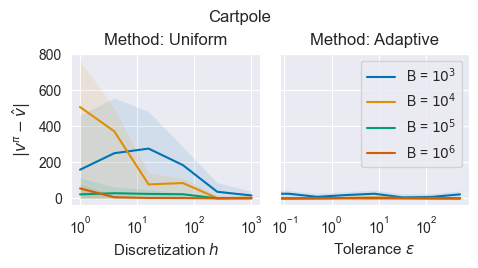

In [34]:


# These must be multiples of BUDGET_INTERP_STEP (usually 1000).
budgets_to_check = np.power(10, np.arange(3, 7, 1))
if SAMPLE_BUDGET >= 2_000_000:
    budgets_to_check *= 2


# budgets_to_check = np.power(10, np.arange(2, 7, 1))

# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: x in good,
#     add_stderr=True)

# fig, axes = plt.subplots(
#     nrows=1, ncols=2, figsize=(8, 4), layout="constrained", sharey=True)

doc_width_pt = 750.0
base_fig_size = set_size(doc_width_pt, 1.0, (1, 2))


fig, axes = plt.subplots(
    nrows=1, ncols=2,
    figsize=(base_fig_size[0]*0.45, base_fig_size[1]*0.8),
    # figsize=set_size(doc_width_pt, 0.48, (1, 2)),
    layout="constrained", sharey=True)

# fig, axes = plt.subplots(
#     nrows=1, ncols=2, figsize=(6, 3), layout="constrained", sharey=True)

# axes[0] will get the uniform results, axes[1] the quadrature results.

# Gather the data for the points on the x-axis.
all_methods = error_data.means.keys()
unif_methods = {
    k: name_to_param(k) for k in all_methods if name_to_type(k) == "u"}
quad_methods = {
    k: name_to_param(k) for k in all_methods if name_to_type(k) == "q"}

unif_xs = sorted(unif_methods.values())
quad_xs = sorted(quad_methods.values())

for ax_idx, ax, xs, method_char in zip(range(2), axes, (unif_xs, quad_xs), ("u", "q")):
    print()
    print("Method:", "uniform" if method_char == "u" else "quadrature")
    for budget_for_curve in tqdm(budgets_to_check):
        print()
        print("Budget: ", budget_for_curve)
        budget_idx = int(budget_for_curve / BUDGET_INTERP_STEP)
        y_means = []
        y_stderrs = []
        try:
            for x in xs:
                y_means.append(error_data.means[param_to_name(method_char, x)][budget_idx])
                y_stderrs.append(error_data.stderrs[param_to_name(method_char, x)][budget_idx])
                # y_means.append(np.nanmean(env_result[x][:, budget_idx]))
                # y_stderrs.append(np.nanstd(env_result[x][:, budget_idx]) / np.sqrt(num_seeds))
            # y_means = np.log2(np.array(y_means))
            # y_stderrs = np.log2(np.array(y_stderrs))
                
            y_means = np.array(y_means)
            y_stderrs = np.array(y_stderrs)

            budget_exp = int(math.log10(budget_for_curve)) 
            ax.plot(
                xs,
                y_means,
                label=f"B = $10^{budget_exp}$" if ax_idx == 1 else ""
            )
            ax.fill_between(
                xs,
                0,
                # (y_means - y_stderrs),
                (y_means + y_stderrs),
                alpha=0.1
            )

            # print("xs", xs)
            # print("y_means:", y_means)
            # print("y_stderrs:", y_stderrs)
        except IndexError:
            pass

    if method_char == "u":
        ax.set_ylabel(error_y_label, fontsize=axes_font_size)
        ax.set_xlabel("Discretization $h$", fontsize=axes_font_size)
        ax.set_title("Method: Uniform")
    else:
        ax.set_xlabel("Tolerance $\epsilon$", fontsize=axes_font_size)
        ax.set_title("Method: Adaptive")

    ax.set_xscale('log')
    # ax.set_yscale('log')
    if ax_idx == 1:
        ax.legend(title="Budget")

# plt.legend(title="Budget")
fig.suptitle(title)
plt.legend()

plt.savefig(f'{filename}_u_shaped2.pdf')
plt.savefig(f"{filename}_u_shaped2.png", dpi=600, format="pdf", bbox_inches="tight")

# def name_to_param(name):
#     return int(name[1:])

# def name_to_type(name):
#     return name[0]

# def param_to_name(param, sampler_char):
#     return f"{sampler_char}{param}"

